In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [5]:
raw_filtered_data = pd.DataFrame(columns = ["Title","Genre","Description"])

In [6]:
with open('train_data.txt','r', encoding='utf-8') as file:
    for i in file:  
        raw_filtered_data.loc[len(raw_filtered_data)] = i[6::].split(" ::: ")

In [7]:
raw_filtered_data

,Title,Genre,Description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...
...,...,...,...
54209,"::: ""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on B...
54210,::: Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The siste...
54211,::: Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about gr..."
54212,::: Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and have...


In [8]:
print(len(raw_filtered_data['Genre'].unique()))
raw_filtered_data['Genre'].unique()

27


array(['drama', 'thriller', 'adult', 'documentary', 'comedy', 'crime',
       'reality-tv', 'horror', 'sport', 'animation', 'action', 'fantasy',
       'short', 'sci-fi', 'music', 'adventure', 'talk-show', 'western',
       'family', 'mystery', 'history', 'news', 'biography', 'romance',
       'game-show', 'musical', 'war'], dtype=object)

In [9]:
genres = ['thriller', 'comedy', 'documentary', 'drama', 'horror', 'short',
       'western', 'family', 'sport', 'romance', 'war', 'game-show',
       'biography', 'adult', 'talk-show', 'action', 'music', 'crime',
       'animation', 'sci-fi', 'adventure', 'reality-tv', 'fantasy',
       'mystery', 'history', 'news', 'musical']

genre_to_int = {genre: i for i, genre in enumerate(genres)}

In [10]:
def make_label(x):
    return genre_to_int[x];

In [11]:
raw_filtered_data['Genre'] = raw_filtered_data['Genre'].map(make_label)
raw_filtered_data

,Title,Genre,Description
0,Oscar et la dame rose (2009),3,Listening in to a conversation between his doc...
1,Cupid (1997),0,A brother and sister with a past incestuous re...
2,"Young, Wild and Wonderful (1980)",13,As the bus empties the students for their fiel...
3,The Secret Sin (1915),3,To help their unemployed father make ends meet...
4,The Unrecovered (2007),3,The film's title refers not only to the un-rec...
...,...,...,...
54209,"::: ""Bonino"" (1953)",1,This short-lived NBC live sitcom centered on B...
54210,::: Dead Girls Don't Cry (????),4,The NEXT Generation of EXPLOITATION. The siste...
54211,::: Ronald Goedemondt: Ze bestaan echt (2008),2,"Ze bestaan echt, is a stand-up comedy about gr..."
54212,::: Make Your Own Bed (1944),1,Walter and Vivian live in the country and have...


In [12]:
print(f"Shape Before: {raw_filtered_data.shape}")
final_filtered_data = raw_filtered_data.drop_duplicates(subset=["Title"], keep='first', inplace=False)
print(f"Shape After:  {final_filtered_data.shape}")

Shape Before: (54214, 3)
Shape After:  (54214, 3)


In [13]:
count_vect = CountVectorizer() # To compute Bag of Words representation(from scikit-learn) 
final_counts = count_vect.fit_transform(final_filtered_data['Description'].values)

In [14]:
import re
import string 
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [15]:
stop_words = stopwords = {
    'a', 'about', 'above', 'after', 'against', 'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'been', 'before',
    'being', 'below', 'between', 'both', 'but', 'by', 'can', 'd', 'do', 'does', 'doing', 'don', 'down', 'during', 'each',
    'few', 'for', 'from', 'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his',
    'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'more', 'most', 'my',
    'myself', 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves',
    'out', 'over', 'own', 're', 's', 'same', 'she', 'should', 'so', 'some', 'such', 't', 'than', 'that', 'the', 'their',
    'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under',
    'until', 'up', 've', 'very', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why',
    'will', 'with', 'y', 'you', 'your', 'yours', 'yourself', 'yourselves'
}
snow = nltk.stem.SnowballStemmer('english')

In [16]:
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',sentence)
    return cleantext

def clean_punctuation(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

In [17]:
genre_words = [[] for _ in range(27)]

In [18]:
i=0
all_spam_words = []
all_normal_words = []
final_strings = []
s = ''
for sent in final_filtered_data['Description']:
    filtered_sentence = []
    sent= cleanhtml(sent)
    for w in sent.split():
        cleaned_word = clean_punctuation(w)
        if((cleaned_word.isalpha()) & (len(cleaned_word)>2)):
            s = (snow.stem(cleaned_word.lower())).encode('utf8')
            filtered_sentence.append(s)
            genre_words[(final_filtered_data['Genre'].values)[i]].append(s);
    strl = b" ".join(filtered_sentence) 
    final_strings.append(strl)  
    i+=1

In [19]:
final_filtered_data = final_filtered_data.copy()
final_filtered_data['Cleaned_Description'] = final_strings

In [20]:
final_filtered_data

,Title,Genre,Description,Cleaned_Description
0,Oscar et la dame rose (2009),3,Listening in to a conversation between his doc...,b'listen convers between his doctor and oscar ...
1,Cupid (1997),0,A brother and sister with a past incestuous re...,b'brother and sister with past incestu relatio...
2,"Young, Wild and Wonderful (1980)",13,As the bus empties the students for their fiel...,b'the bus empti the student for their field tr...
3,The Secret Sin (1915),3,To help their unemployed father make ends meet...,b'help their unemploy father make end edith an...
4,The Unrecovered (2007),3,The film's title refers not only to the un-rec...,b'the film titl refer not onli the bodi ground...
...,...,...,...,...
54209,"::: ""Bonino"" (1953)",1,This short-lived NBC live sitcom centered on B...,b'this nbc live sitcom center concert singer w...
54210,::: Dead Girls Don't Cry (????),4,The NEXT Generation of EXPLOITATION. The siste...,b'the next generat the sister kapa bay soror h...
54211,::: Ronald Goedemondt: Ze bestaan echt (2008),2,"Ze bestaan echt, is a stand-up comedy about gr...",b'bestaan comedi about grow and face your free...
54212,::: Make Your Own Bed (1944),1,Walter and Vivian live in the country and have...,b'walter and vivian live the countri and have ...


In [21]:
conn = sqlite3.connect('final.sqlite')
c = conn.cursor()
conn.text_factory = str
final_filtered_data.to_sql('Messages', conn,schema = None, if_exists = 'replace')

54214

In [22]:
conn = sqlite3.connect('final.sqlite')
final_filtered_data = pd.read_sql_query("""
SELECT *
FROM messages
""",conn)

In [23]:
for i in range(27):
    count_result = pd.read_sql_query(f"""
    SELECT count(*)
    FROM messages
    WHERE Genre = {i}
    """, conn)
    count_value = count_result.iloc[0, 0]  # Extract count value from DataFrame
    print(f"{genres[i]}: {count_value}")

thriller: 1591
comedy: 7447
documentary: 13096
drama: 13613
horror: 2204
short: 5073
western: 1032
family: 784
sport: 432
romance: 672
war: 132
game-show: 194
biography: 265
adult: 590
talk-show: 391
action: 1315
music: 731
crime: 505
animation: 498
sci-fi: 647
adventure: 775
reality-tv: 884
fantasy: 323
mystery: 319
history: 243
news: 181
musical: 277


In [24]:
for i in range(27):
    print(f"{genres[i]}: {genre_words[i][0:10]}")

thriller: [b'brother', b'and', b'sister', b'with', b'past', b'incestu', b'relationship', b'have', b'current', b'murder']
comedy: [b'tough', b'econom', b'time', b'max', b'and', b'joey', b'have', b'all', b'but', b'run']
documentary: [b'qualiti', b'control', b'consist', b'seri', b'singl', b'take', b'shot', b'film', b'the', b'summer']
drama: [b'listen', b'convers', b'between', b'his', b'doctor', b'and', b'oscar', b'learn', b'what', b'nobodi']
horror: [b'four', b'high', b'school', b'student', b'embark', b'terrifi', b'journey', b'through', b'shadowview', b'manor']
short: [b'brian', b'wallac', b'cameraman', b'for', b'the', b'hit', b'ride', b'minut', b'was', b'haul']
western: [b'santa', b'dolor', b'small', b'western', b'town', b'that', b'haven', b'for', b'outlaw', b'and']
family: [b'lyle', b'licketti', b'never', b'ever', b'doe', b'his', b'whether', b'alien', b'who', b'stole']
sport: [b'modern', b'roller', b'derbi', b'began', b'and', b'quick', b'spread', b'creat', b'hundr', b'place']
romance: [

In [25]:
freq_dist_positive = nltk.FreqDist(all_spam_words)
freq_dist_negative = nltk.FreqDist(all_normal_words)
freq_dist_positive

FreqDist({})

In [26]:
freq_dist_genre = [[] for _ in range(27)]

In [27]:
for i in range(27):
    freq_dist_genre[i] = nltk.FreqDist(genre_words[i])

In [28]:
for i in range(27):
    print(f"Most common {genres[i]} words: ",freq_dist_genre[i].most_common()[:10])

Most common thriller words:  [(b'the', 8711), (b'and', 4890), (b'his', 2355), (b'her', 1866), (b'with', 1523), (b'that', 1414), (b'for', 1147), (b'she', 1071), (b'who', 925), (b'but', 812)]
Most common comedy words:  [(b'the', 36115), (b'and', 22302), (b'his', 11320), (b'with', 7332), (b'her', 5510), (b'for', 5494), (b'that', 5201), (b'their', 4610), (b'who', 4047), (b'they', 4034)]
Most common documentary words:  [(b'the', 99942), (b'and', 53076), (b'with', 11392), (b'for', 10199), (b'that', 9827), (b'their', 9183), (b'his', 9147), (b'from', 8677), (b'this', 8612), (b'film', 6576)]
Most common drama words:  [(b'the', 78197), (b'and', 48808), (b'his', 24929), (b'her', 19903), (b'with', 15984), (b'for', 11476), (b'that', 11374), (b'she', 10998), (b'who', 9148), (b'their', 8361)]
Most common horror words:  [(b'the', 14431), (b'and', 6901), (b'his', 2608), (b'her', 2264), (b'that', 2116), (b'with', 1975), (b'they', 1726), (b'for', 1661), (b'their', 1459), (b'who', 1267)]
Most common short

# TF-IDF

In [44]:
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_filtered_data['Cleaned_Description'].values)

In [45]:
final_tf_idf

<54214x1371893 sparse matrix of type '<class 'numpy.float64'>'
	with 6409619 stored elements in Compressed Sparse Row format>

In [46]:
features = tf_idf_vect.get_feature_names_out()
len(features)

1371893

In [47]:
features[100000:100010]

array(['avi bridg', 'avi director', 'avi effort', 'avi experi',
       'avi india', 'avi jewish', 'avi learn', 'avi leav', 'avi lewi',
       'avi quick'], dtype=object)

In [48]:
print(len(final_tf_idf[3,:].toarray()[0]))

1371893


In [49]:
def top_tfidf_features(row,features,top_n=25):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_features(final_tf_idf[1,:].toarray()[0], features,25)

In [50]:
top_tfidf

,feature,tfidf
0,murder the,0.268258
1,murder,0.262086
2,women who,0.249931
3,the women,0.241080
4,past incestu,0.225027
5,have current,0.225027
6,current murder,0.216886
7,murder murder,0.211110
8,incestu relationship,0.199874
9,relationship have,0.199874


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [52]:
final_tf_idf

<54214x1371893 sparse matrix of type '<class 'numpy.float64'>'
	with 6409619 stored elements in Compressed Sparse Row format>

In [53]:
y_final = final_filtered_data['Genre']

In [54]:
x_train, x_test, y_train, y_test = train_test_split(final_tf_idf,y_final,train_size = 0.7,random_state = 42) 

### XGBoost

In [55]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
import seaborn as sbn

In [56]:
model = XGBClassifier()

In [57]:
model.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [58]:
predictions = model.predict(x_test)

In [59]:
accuracy = accuracy_score(predictions,y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5326775284352905


In [60]:
confusion_mat_xgbc = confusion_matrix(predictions,y_test)

In [61]:
class_labels = genres

In [62]:
def plot_confusion_matrix(cm):
    df_cm = pd.DataFrame(cm, index = [i for i in class_labels],
                         columns = [i for i in class_labels])
    plt.figure(figsize = (15,15))
    sbn.heatmap(df_cm, annot=True,fmt ='d')

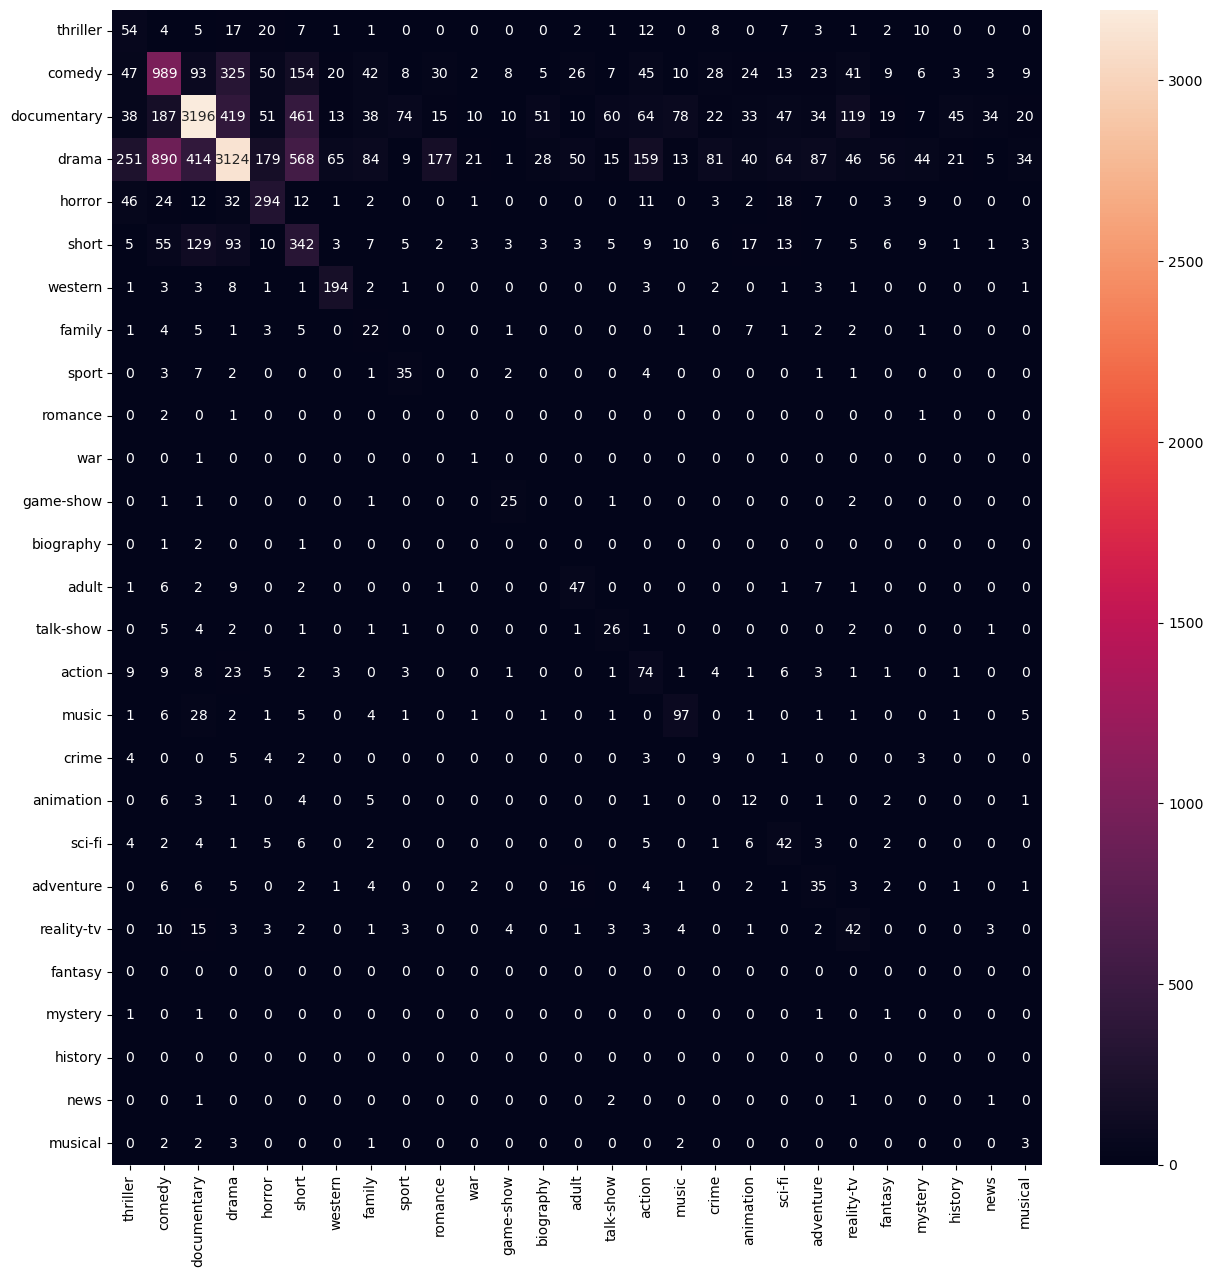

In [63]:
plot_confusion_matrix(confusion_mat_xgbc)

In [64]:
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier

def objective(trial):
    max_depth = trial.suggest_int("max_depth", 10,30)
    min_child_weight = trial.suggest_float("min_child_weight", 0, 10)
    gamma = trial.suggest_float("gamma", 0, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0, 1)
    subsample = trial.suggest_float("subsample", 0, 1)
    reg_alpha = trial.suggest_float("reg_alpha", 0, 1)
    n_estimators = trial.suggest_int("n_estimators", 64, 128)
    
    params = {
        "max_depth": max_depth,
        "min_child_weight": min_child_weight,
        "gamma": gamma,
        "colsample_bytree": colsample_bytree,
        "subsample": subsample,
        "reg_alpha": reg_alpha,
        "n_estimators": n_estimators,
        "num_class": 27
    }
    
    params["learning_rate"] = 0.1
    params["objective"] = "multi:softmax"
    params["nthread"] = -1
    
    model = XGBClassifier(**params)

    cv_results = cross_validate(model, x_train, y_train, cv=3, scoring='accuracy')
    validation_score = np.mean(cv_results['test_score'])
    
    return -validation_score  # Optimize for the negative of the validation score

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)  # Minimize the negative validation score
study.optimize(objective, n_trials=500)
df_study = study.trials_dataframe()
df_study_best = df_study.sort_values(by='value', ascending=True)
best_params = study.best_params
print(best_params)


## Similar results were obtained even after fine-tuning

# Naive Bayes

In [69]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

In [71]:
gnb = BernoulliNB()
y_pred = gnb.fit(x_train, y_train).predict(x_test)